In [95]:
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.data import DataLoader, Dataset
from pathlib import Path
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import ResNet
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric
import os

os.chdir('/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Anne/DL-3D-Anhinga')

In [96]:
def get_bugnist_2D_Data(dataset_path):
    dataset = []
    classes = os.listdir(dataset_path)
    for i, class_ in enumerate(classes):
        folders = os.listdir(os.path.join(dataset_path, class_))
        one_hot_encoded_label = np.zeros(len(classes))
        one_hot_encoded_label[i] = 1
        for folder in folders:
            # list only npy files
            files = [f for f in os.listdir(os.path.join(dataset_path, class_, folder)) if f.endswith('.npy')]#os.listdir(os.path.join(dataset_path, class_, folder))
            dataset.append({'projection_01': os.path.join(dataset_path, class_, folder, files[0]),
                        'projection_02': os.path.join(dataset_path, class_, folder, files[1]),
                        'projection_03': os.path.join(dataset_path, class_, folder, files[2]),
                        'label': one_hot_encoded_label,
                        'class': class_})
        
    return dataset


In [97]:
DATA_PATH = "data"
dataset = get_bugnist_2D_Data(DATA_PATH)
train_split = 0.8
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_size = int(len(dataset) * train_split)
val_size = int(train_size*0.2)
train_size = train_size - val_size

idx = np.random.permutation(len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size:train_size+val_size]
test_idx = idx[train_size+val_size:]

train_files = [dataset[i] for i in train_idx]
val_files = [dataset[i] for i in val_idx]
test_files = [dataset[i] for i in test_idx]


In [102]:
train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['projection_01','projection_02','projection_03'], ensure_channel_first=True),
])
val_transforms = monai.transforms.Compose([
    monai.transforms.LoadImage(keys=['projection_01','projection_02','projection_03'], ensure_channel_first=True),
])
test_transforms = monai.transforms.Compose([
    monai.transforms.LoadImage(keys=['projection_01', 'projection_02', 'projection_03'], ensure_channel_first=True),
])

train_dataset = Dataset(data=train_files, transform=train_transforms)
val_dataset = Dataset(data=val_files, transform=val_transforms)
test_dataset = Dataset(data=test_files, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=6)

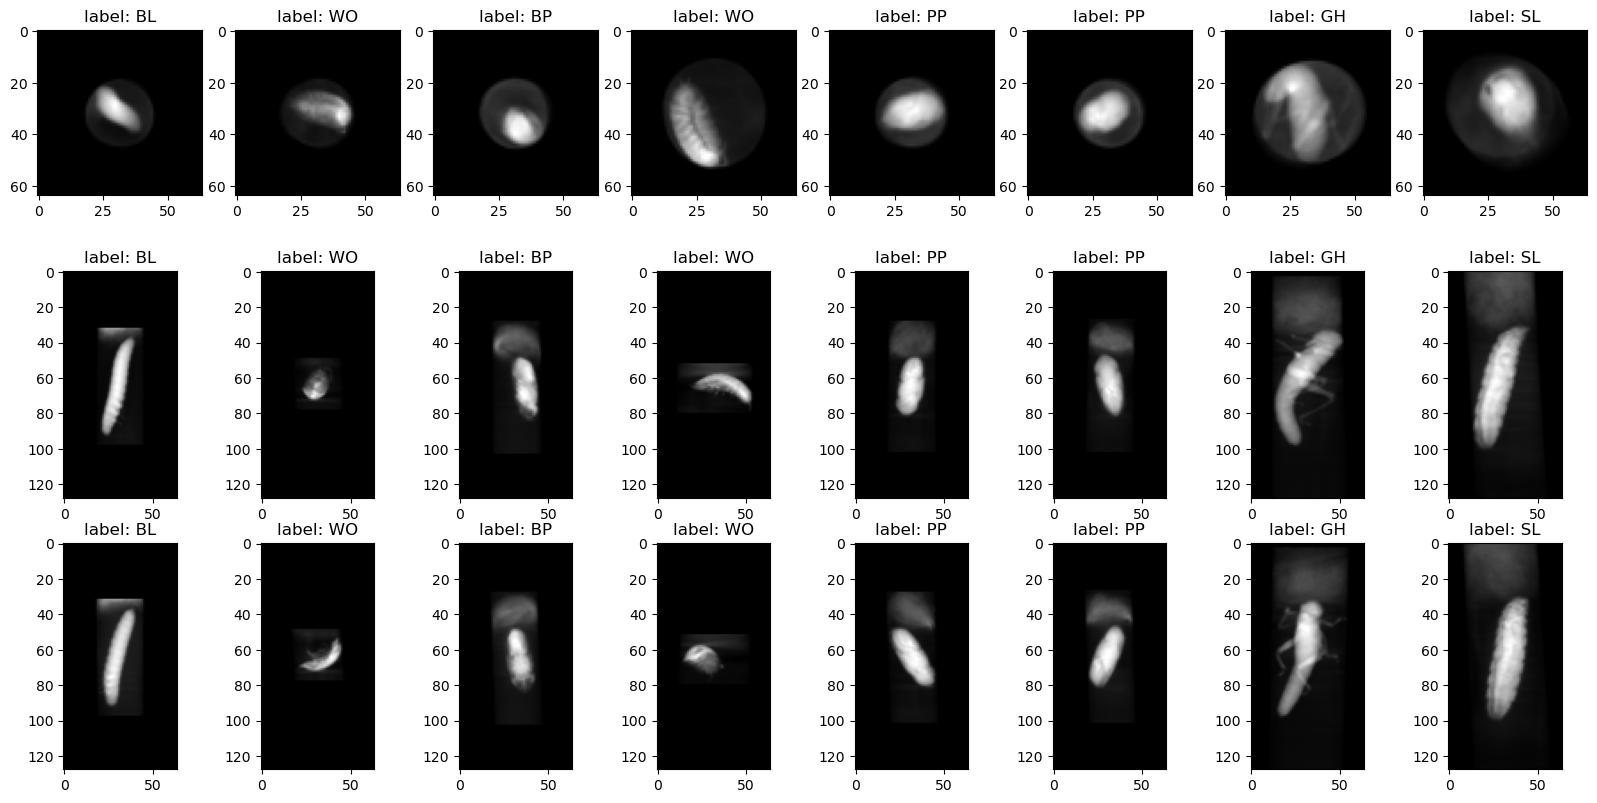

In [113]:
# Visualize one batch
batch = next(iter(train_loader))

classes = batch['class']

fig, ax = plt.subplots(3, 8, figsize=(20, 10))
for j in range(3):
    images = batch[f'projection_0{j+1}']
    for i in range(8):
        ax[j,i].imshow(images[i, 0, :, :], cmap='gray')
        ax[j,i].set_title('label: '+ classes[i])
plt.show()
